# Training Deep Convolutional Neural Network
- Name1, Student's ID1
- Name2, Student's ID2

Name your file to (first 2 student ID digit)_(last 4 student ID digit)*4.ipynb

## Lab Instruction

In this lab, you will learn to train a deep convolutional neural network using Keras library with Tensorflow backend. We will use  Cat vs Dog dataset.

See https://www.kaggle.com/c/dogs-vs-cats/data


### Your Turn! Dog or Cat Application

Now, it time to put everything together and develop and Cat vs Dog classifier model. Assume that you and your company want to get more attraction on your product by launching a new product that can classify whether it is a dog or a cat. You have decide that you want a precision more than 90 - 95% in order to launch to product.

You have a cat and dog dataset contain total of 25000 images, 12500 for cat and other half for a dog.

After successfully develop this model, you can try to play with it to see how it perform. (You can upload your selfies image to see you are a dog or a cat)

Some note before start a project:
1. You have to load a data into a project using any method
**suggest**
   

```
 !wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
 !unzip -qq Cat_Dog_data.zip
```


2. You have to plan on how you will split a data. (or no need for suggest method)
3. You have to preprocess your data before feed into a network. For example, cropping, padding, etc.
4. You can come up with any model or use pre-train model. It depend on you!

You have two week for this project so that you can compete with your competitor app! Now, create a new Jupyter notebook and start building a model!

In [1]:
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import backend as K
from keras.preprocessing import image
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# %load _utils
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras import backend as K

# Test
def print_hello():
    print('Hello')

# define a function to plot the result from training step
def show_result(history):

    # Print the result from the last epoch
    print('Last train accuracy: %s'%history.history['accuracy'][-1])
    print('Last validation accuracy: %s'%history.history['val_acc'][-1])

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    acc = history.history['accuracy']
    val_acc = history.history['val_acc']

    epochs = range(1, len(loss) + 1)

    # Define a subplot
    fig, axs = plt.subplots(1,2,figsize=(15,4))

    # Plot loss
    loss_plot = axs[0]

    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()

    # Plot accuracy
    acc_plot = axs[1]

    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

# Define an evaluation function to print the evaluation result
def evaluation_report(model,features,labels):

    # Calculate result
    result = model.evaluate(features,labels,verbose=False)

    # Predict and convert into a class
    pred_class = model.predict(features).argmax(axis=1)
    labels = labels.argmax(axis=1)
    # Show report
    print(confusion_matrix(labels,pred_class))
    print(classification_report(labels,pred_class))
    print("Loss: %s Accuracy: %s" %(result[0],result[1]))

    return pred_class


# Show a subplot of the incorrect predict data
def show_false_prediction(predict, feature, label, img_size=28, channel=1):

    false_pred = feature[(predict != label).tolist()]
    actual_label = label[(predict != label).tolist()]
    false_label = predict[(predict != label).tolist()]
    if channel == 3:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size,channel)
    elif channel == 1:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size)
    else:
        raise ValueError('Must be RGB or gray scale image')

    print(false_pred.shape)

    fig, ax = plt.subplots(3,10,figsize=(15,6))
    fig.suptitle('The incorrect prediction')

    for i in range(3):
        for j in range(10):
            ax[i,j].imshow(false_pred[j + i*10],cmap='gray')
            ax[i,j].set_title('Pred %s Act %s'%(false_label[j + i*10],actual_label[j + i*10]))

# Show activation value of each layer
def show_layer_activation(activation, model,num_layer,num_row=16):
    layer_names = []
    for layer in model.layers[:num_layer]:
        layer_names.append(layer.name)

    images_per_row = num_row
    for layer_name, layer_activation in zip(layer_names,activation):
        n_features = layer_activation.shape[-1]

        size = layer_activation.shape[1]

        n_cols = n_features//images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:,:,col*images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0,255).astype('uint8')
                display_grid[col*size:(col +1)*size,
                             row*size:(row+1)*size] = channel_image
        scale = 1./size
        plt.figure(figsize=(scale*display_grid.shape[1],
                           scale*display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')


def deprocess_image(img):

    # Zero-centering and make sure that std is 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1

    # Clips to [0,1]
    img += 0.5
    img = np.clip(img,0,1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img,0,255).astype('uint8')

    return img

def generate_pattern(model, layer_name , filter_index, size=150):
    # Build the loss function that maximize the activation of the nth filter of the layer under consideration
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])

    # Compute the gradient of the input picture with regard to this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5)

    # Return the loss and gradient given the input picture
    iterate = K.function([model.input],[loss, grads])

    # Stars from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 step
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    img = input_img_data[0]
    return deprocess_image(img)

### feed layer name. ie, 'conv_1'
def visualize_filter(model,layer_name, size= 64, margin = 5):

    # Empty black image to store results
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    # iterate over the row of result grid
    for i in range(8):
        # Iterate over the column of the result grid
        for j in range(8):
            # Generates the pattern for filter i + (j*8) in layer_name
            filter_img = generate_pattern(model, layer_name, i + (j*8), size=size)

            # Puts the result in the square (i,j) of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start:horizontal_end,
                    vertical_start:vertical_end, :] = filter_img

    plt.figure(figsize=(20,20))
    plt.imshow(results)

Load dataset

In [3]:
 !wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
 !unzip -qq Cat_Dog_data.zip

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-10-15 16:32:53--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.57.56, 52.216.211.152, 52.216.33.144, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.57.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580495262 (554M) [application/zip]
Saving to: 'Cat_Dog_data.zip'

Cat_Dog_data.zip    100%[===================>] 553.60M  51.5MB/s    in 11s     

2024-10-15 16:33:05 (48.6 MB/s) - 'Cat_Dog_data.zip' saved [580495262/580495262]



In [101]:
# pip install --upgrade tensorflow keras










































   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.8 MB/s eta 0:00:00


  Attempting uninstall: keras

    Found existing installation: keras 3.4.1

    Uninstalling keras-3.4.1:

      Successfully uninstalled keras-3.4.1



In [4]:
!sudo apt-get -q install tree

Reading package lists...
Building dependency tree...
Reading state information...
tree is already the newest version (2.0.2-1).
0 upgraded, 0 newly installed, 0 to remove and 68 not upgraded.


In [5]:
!tree -d ./Cat_Dog_data

./Cat_Dog_data
|-- test
|   |-- cat
|   `-- dog
`-- train
    |-- cat
    `-- dog

6 directories


In [6]:
import os
import shutil
import random

# Define the paths
data_dir = './Cat_Dog_data'
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')

# Create the validation directory and subdirectories
os.makedirs(os.path.join(valid_dir, 'cat'), exist_ok=True)
os.makedirs(os.path.join(valid_dir, 'dog'), exist_ok=True)

# Define the percentage of data to move to the validation set
validation_split = 0.2

# Loop through the training cat and dog directories
for class_name in ['cat', 'dog']:
    source_dir = os.path.join(train_dir, class_name)
    destination_dir = os.path.join(valid_dir, class_name)

    # Get the list of files in the source directory
    files = os.listdir(source_dir)

    # Calculate the number of files to move to the validation set
    num_validation_files = int(len(files) * validation_split)

    # Randomly select files to move
    validation_files = random.sample(files, num_validation_files)

    # Move the selected files to the validation directory
    for file_name in validation_files:
        source_file = os.path.join(source_dir, file_name)
        destination_file = os.path.join(destination_dir, file_name)
        shutil.move(source_file, destination_file)

print('Validation data created successfully!')


Validation data created successfully!


In [43]:
import glob

# Count the number of files in the Cat_Dog_data directory
train_cat_count = len(glob.glob('./Cat_Dog_data/train/cat/*.jpg'))
train_dog_count = len(glob.glob('./Cat_Dog_data/train/dog/*.jpg'))

# Count the number of files in the Cat_Dog_data directory
valid_cat_count = len(glob.glob('./Cat_Dog_data/valid/cat/*.jpg'))
valid_dog_count = len(glob.glob('./Cat_Dog_data/valid/dog/*.jpg'))


test_cat_count = len(glob.glob('./Cat_Dog_data/test/cat/*.jpg'))
test_dog_count = len(glob.glob('./Cat_Dog_data/test/dog/*.jpg'))


print("Train: cat image count:", train_cat_count)
print("Train: dog image count:", train_dog_count)

print("Valid: cat image count:", valid_cat_count)
print("Valid: dog image count:", valid_dog_count)

print("Test: cat image count:", test_cat_count)
print("Test: dog image count:", test_dog_count)

Train: cat image count: 9000
Train: dog image count: 9000
Valid: cat image count: 2250
Valid: dog image count: 2250
Test: cat image count: 1250
Test: dog image count: 1250


In [44]:
!tree -d ./Cat_Dog_data

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


./Cat_Dog_data
|-- test
|   |-- cat
|   `-- dog
|-- train
|   |-- cat
|   `-- dog
`-- valid
    |-- cat
    `-- dog

9 directories


In [45]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224 , 224)
batch_size = 32

# ImageDataGenerator for training with data augmentation
train_datagen = ImageDataGenerator()

# ImageDataGenerator for validation and testing (no augmentation, only rescaling)
test_datagen = ImageDataGenerator()

# Training data generator
train_generator = train_datagen.flow_from_directory(
    './Cat_Dog_data/train',     # Directory containing training data
    target_size=img_size,     # Resize images to 128x128
    batch_size=batch_size,             # Batch size
    class_mode='binary',        # Binary class mode for 2 classes (Cats and Dogs)
    shuffle=True
)

# Validation data generator
valid_generator = test_datagen.flow_from_directory(
    './Cat_Dog_data/valid',     # Directory containing validation data
    target_size=img_size,     # Resize images to 128x128
    batch_size=batch_size,             # Batch size
    class_mode='binary',        # Binary class mode
    shuffle=True
)

# Test data generator
test_generator = test_datagen.flow_from_directory(
    './Cat_Dog_data/test',      # Directory containing test data
    target_size=img_size,     # Resize images to 128x128
    batch_size=batch_size,             # Batch size
    class_mode='binary',        # Binary class mode
    shuffle=False
)

Found 18000 images belonging to 2 classes.
Found 4500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


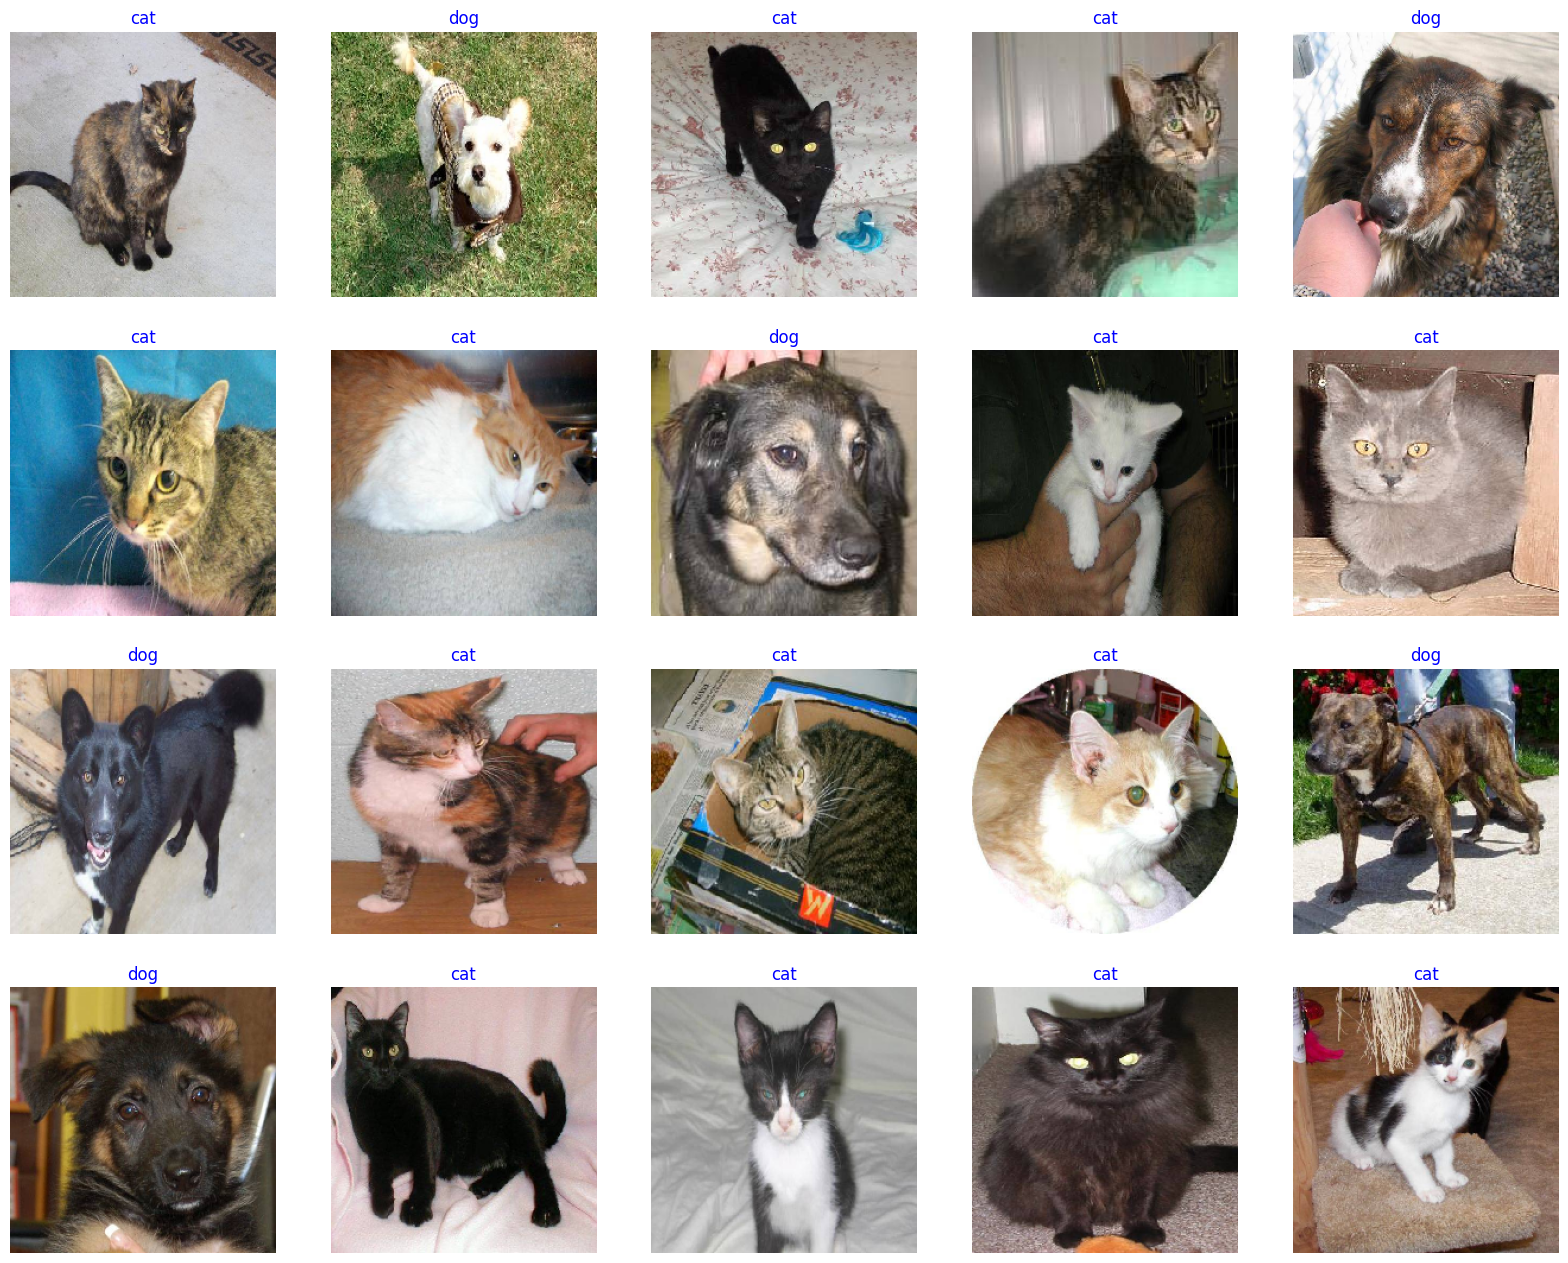

In [48]:
g_dict = train_generator.class_indices
classes = list(g_dict.keys())
images, labels = next(train_generator)
num_samples = len(images)

plt.figure(figsize=(20, 20))

for i in range(min(20, num_samples)):
    plt.subplot(5, 5, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    class_index = int(labels[i])
    class_name = classes[class_index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()

In [52]:
import tensorflow as tf
from keras.applications import ResNet50, VGG16 
from keras.applications.efficientnet import EfficientNetB5
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam, Adamax
from keras.callbacks import EarlyStopping

In [53]:
img_shape = (img_size[0] , img_size[1] , 3)

# Step 1: Load Pretrained ResNet model (without top layers)
base_model = EfficientNetB5(include_top= False , 
                            weights= 'imagenet' ,
                            input_shape= img_shape,pooling= 'max')

base_model.trainable= False

# Step 3: Add custom classification layers
model = Sequential([
    base_model,
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),  # L2 regularization
    BatchNormalization(),               # Batch normalization to stabilize training
    Dropout(0.3),                       # Increase dropout rate for better regularization
    Dense(1, activation='sigmoid')      # Sigmoid activation for binary classification (Cats and Dogs)
])


In [54]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb5 (Functional)     │ ?                      │    28,513,527 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,513,527 (108.77 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 28,513,527 (108.77 MB)

In [55]:

# Step 4: Compile the model
model.compile(
    optimizer=Adamax(learning_rate=0.001),  # Use Adam optimizer
    loss='binary_crossentropy',           # Binary cross-entropy loss
    metrics=['accuracy']                  # Track accuracy
)

In [56]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


# Define the callbacks
checkpoint = ModelCheckpoint(
    filepath='./cat_dog_classifier.keras',  # Filepath to save the model
    monitor='val_loss',                     # Monitor validation loss
    save_best_only=True,                    # Save only the best model (based on val_loss)
    save_weights_only=False,                # Save the entire model (architecture + weights)
    verbose=1
)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.05, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True, verbose=1)


In [57]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [58]:
# Train the model
history = model.fit(
    train_generator,                      # Training data generator
    validation_data=valid_generator,      # Validation data generator
    epochs=10,                            # Set the number of epochs
    validation_steps = None , 
    shuffle = False,
    callbacks=[checkpoint, reduce_lr, early_stopping],  # Add the callbacks
)


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9683 - loss: 0.7772
Epoch 1: val_loss improved from inf to 0.53842, saving model to ./cat_dog_classifier.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 248s 275ms/step - accuracy: 0.9683 - loss: 0.7770 - val_accuracy: 0.9849 - val_loss: 0.5384 - learning_rate: 0.0010
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9821 - loss: 0.5005
Epoch 2: val_loss improved from 0.53842 to 0.39007, saving model to ./cat_dog_classifier.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 67s 120ms/step - accuracy: 0.9821 - loss: 0.5005 - val_accuracy: 0.9838 - val_loss: 0.3901 - learning_rate: 0.0010
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9870 - loss: 0.3569
Epoch 3: val_loss improved from 0.39007 to 0.28960, saving model to ./cat_dog_classifier.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 68s 120ms/step - accuracy: 0.9870 - loss: 0.3568 - val_accuracy: 0.9884 - val_loss: 0.2896 - learning_rate: 0.0010
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━

In [59]:
# Step 6: Evaluate the model on the test data
test_loss, test_acc = model.evaluate(
    test_generator,
    steps=test_generator.samples // test_generator.batch_size
)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.9864 - loss: 0.1460
Test Loss: 0.14208102226257324
Test Accuracy: 0.9871794581413269


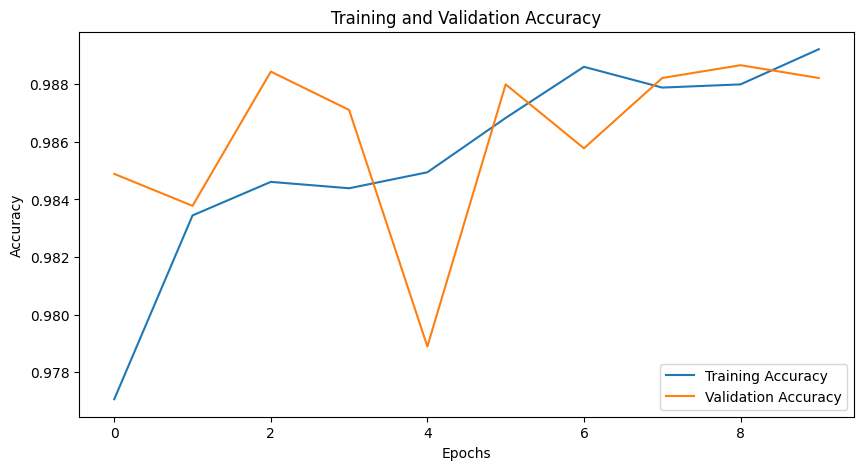

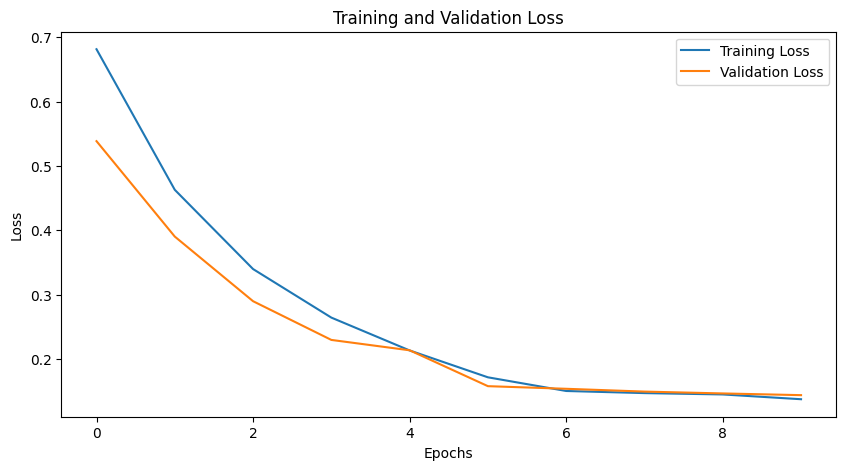

In [60]:
import matplotlib.pyplot as plt

# Plot accuracy history
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss history
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()